# dataloader demo

In [1]:
# Jupyter notebook setup
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Standard imports
import sys
import os
from pathlib import Path

# Add project root to path if needed
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm
import torch
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset
from experanto.dataloaders import get_multisession_dataloader

#### Load Config Object from .yaml file

In [3]:
from experanto.configs import DEFAULT_CONFIG as cfg

print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  add_behavior_as_channels: false
  replace_nans_with_means: false
  cache_data: false
  out_keys:
  - screen
  - responses
  - eye_tracker
  - treadmill
  - timestamps
  normalize_timestamps: true
  modality_config:
    screen:
      keep_nans: false
      sampling_rate: 30
      chunk_size: 60
      valid_condition:
        tier: train
      offset: 0
      sample_stride: 1
      include_blanks: true
      transforms:
        normalization: normalize
        Resize:
          _target_: torchvision.transforms.v2.Resize
          size:
          - 144
          - 256
      interpolation:
        rescale: true
        rescale_size:
        - 144
        - 256
    responses:
      keep_nans: false
      sampling_rate: 8
      chunk_size: 16
      offset: 0.0
      transforms:
        normalization: standardize
      interpolation:
        interpolation_mode: nearest_neighbor
      filters:
        nan_filter:
          __tar

#### Modify the config

In [4]:
cfg.dataset.modality_config.screen.include_blanks = True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataloader.num_workers = 8

#### Instantiate dataloader

In [5]:
from experanto.dataloaders import get_multisession_dataloader

paths = ["/data/test_upsampling_without_hamming_30.0Hz/dynamic29515-10-12-Video-021a75e56847d574b9acbcc06c675055_30hz"]
train_dl = get_multisession_dataloader(paths, cfg)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
dataset_name, batch = next(iter(train_dl))
print(
    f"dataset: {dataset_name}",
)
for k, v in batch.items():
    # print(f"modality: {k}, shape: {v.shape}")
    print("Modality: ", k)
    print("Shape: ", v.shape)

# video shape: batch, times, channels, height, width
# neuronal responses: batch, times, neurons

dataset: 29515-10-12
Modality:  eye_tracker
Shape:  torch.Size([16, 60, 4])
Modality:  responses
Shape:  torch.Size([16, 16, 7863])
Modality:  screen
Shape:  torch.Size([16, 1, 60, 144, 256])
Modality:  treadmill
Shape:  torch.Size([16, 60, 1])
Modality:  timestamps


AttributeError: 'dict' object has no attribute 'shape'

## example content

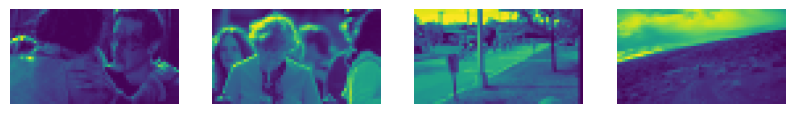

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(batch["screen"][i, 0, 0])  # video frames that the mouse sees
    ax.axis("off");

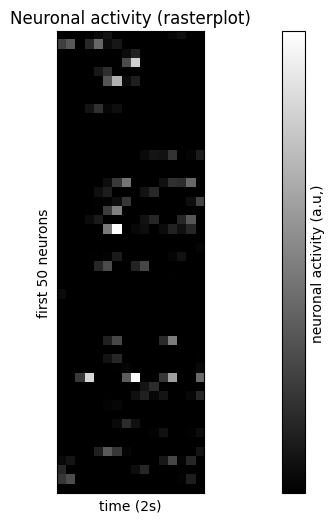

In [8]:
n_neurons = 50

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
c = axs.imshow(batch["responses"][0, :, :n_neurons].T, vmin=0, cmap="gray")
axs.set(
    ylabel=f"first {n_neurons} neurons",
    xlabel="time (2s)",
    xticks=[],
    yticks=[],
    title="Neuronal activity (rasterplot)",
)
ax = plt.colorbar(c)
ax.ax.set(yticks=[], ylabel="neuronal activity (a.u,)");